In [2]:
!pip install rasterio 
!pip install geopandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.1/20.1 MB 69.5 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 78.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 66.6 MB/s eta 0:00:00


In [3]:
import os
import glob

import rasterio
from rasterio.plot import reshape_as_image
import rasterio.mask
from rasterio.features import rasterize
import geopandas as gpd
from shapely.geometry import mapping, Point, Polygon
from shapely.ops import cascaded_union

import numpy as np 
from keras.models import Model
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras
import shutil

from PIL import Image
import pandas as pd
from sklearn.model_selection import train_test_split

import cv2
import matplotlib.pyplot as plt

# uncomment if you run it in google colab 
from google.colab import drive 
drive.mount('/content/drive')

%matplotlib inline

Mounted at /content/drive


### Loading data

In [4]:
raster_path = '/content/drive/MyDrive/T36UXV_20200406T083559_TCI_10m.jp2'
with rasterio.open(raster_path, "r", driver="JP2OpenJPEG") as src:
    raster_img = src.read()
    raster_meta = src.meta

In [5]:
train_df = gpd.read_file("/content/drive/MyDrive/masks")
print(len(train_df))
train_df.head()

ERROR:fiona._env:Pointer 'hGeom' is NULL in 'OGR_G_GetGeometryType'.



936


,id,Data,Code,Descriptio,Comments,Image,geometry
0,NaN,NaN,2.0,branch of tree,NaN,T36UXV_20190427T083601,"POLYGON ((35.62916 49.60293, 35.63015 49.60163..."
1,NaN,NaN,1.0,color+ feathers,NaN,T36UXV_20190427T083601,"POLYGON ((35.65070 49.60254, 35.65248 49.60301..."
2,NaN,NaN,2.0,brahch of tree,NaN,T36UXV_20190427T083601,"POLYGON ((35.63023 49.60826, 35.62960 49.60920..."
3,NaN,NaN,1.0,color+ feathers,NaN,T36UXV_20190427T083601,"POLYGON ((35.62033 49.60905, 35.62064 49.60968..."
4,NaN,NaN,1.0,color+ feathers,NaN,T36UXV_20190427T083601,"POLYGON ((35.60455 49.61078, 35.60597 49.61228..."


In [6]:
raster_img = reshape_as_image(raster_img)

In [7]:
train_df['geometry'][0].exterior.coords.xy

(array('d', [35.62916346617293, 35.63014960535702, 35.631175190108465, 35.631214635675825, 35.630031268654925, 35.62888734720139, 35.62813788142149, 35.62774342574785, 35.62813788142149, 35.62916346617293]),
 array('d', [49.602931546762534, 49.60162984303954, 49.60080148612491, 49.59981534694083, 49.6001703570471, 49.60111705066382, 49.60214263541526, 49.60289210119517, 49.60312877459935, 49.602931546762534]))

Using website http://projfinder.com/ and coordination we`ll find epsg for our masks

In [8]:
train_df = train_df[train_df.geometry.notnull()]
train_df.crs = "epsg:4267"
train_df = train_df.to_crs(raster_meta['crs']['init'])

### Data vizualization 

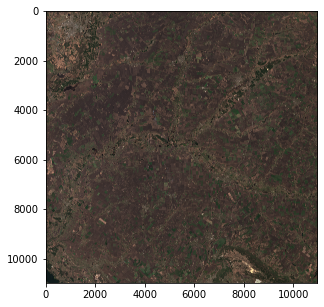

In [9]:
# plotting the image
plt.figure(figsize=(5,5))
plt.imshow(raster_img)

<ipython-input-10-b5d322831627>:4: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  poly = cascaded_union(polygon)


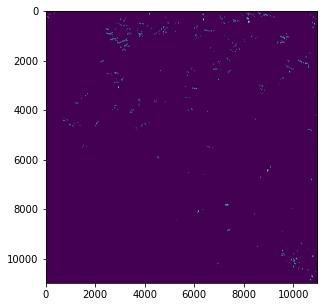

In [10]:
def poly_from_utm(polygon, transform):
    poly_pts = []
    
    poly = cascaded_union(polygon)
    for i in np.array(poly.exterior.coords):
        poly_pts.append(~transform * tuple(i))
        
    new_poly = Polygon(poly_pts)
    return new_poly

# creating binary mask for field/not_filed segmentation.

poly_shp = []
im_size = (src.meta['height'], src.meta['width'])
for num, row in train_df.iterrows():
    if row['geometry'].geom_type == 'Polygon':
        poly = poly_from_utm(row['geometry'], src.meta['transform'])
        poly_shp.append(poly)
    else:
        for p in row['geometry']:
            poly = poly_from_utm(p, src.meta['transform'])
            poly_shp.append(poly)

mask = rasterize(shapes=poly_shp,
                 out_shape=im_size)

# plotting the mask

plt.figure(figsize=(5,5))
plt.imshow(mask)

### Preparing data

In [11]:
height, width, _ = raster_img.shape

tile_size = (128, 128)

small_images = [raster_img[x:x+tile_size[0], y:y+tile_size[1]] for x in range(0, height, tile_size[0]) for y in range(0, width, tile_size[1])]
outfolder = "images128"
os.makedirs(outfolder, exist_ok=True)
small_mask = [mask[x:x+tile_size[0], y:y+tile_size[1]] for x in range(0, height, tile_size[0]) for y in range(0, width, tile_size[1])]
outfolder = "target128"
os.makedirs(outfolder, exist_ok=True)

counter = 0
for i, small_image in enumerate(small_images):
  if (small_mask[i] != np.zeros(small_mask[i].shape)).any(): 
      Image.fromarray(small_image).save(f"images128/small_image_{i}.png")
      Image.fromarray(small_mask[i]).save(f"target128/small_image_{i}.png")
  else:
    # we have a lot of space without erosion so I deciced to add not all of them to thain data
    if counter % 100 == 0:
      Image.fromarray(small_image).save(f"images128/small_image_{i}.png")
      Image.fromarray(small_mask[i]).save(f"target128/small_image_{i}.png")
    counter+=1  
     

  

#### Data audumentation

In [15]:
# function for resizing images 
def load_resize_image(img_path, resize_shape):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, resize_shape)
    return img

# function for resizing masks
def load_resize_mask(mask_path, resize_shape):
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, resize_shape, interpolation=cv2.INTER_NEAREST)
    mask = np.expand_dims(mask, axis=-1)
    return mask

# horizontal flip function
def flip_hor(image):
    return cv2.flip(image, 1)

# vertical flip function
def flip_vert(image):
    return cv2.flip(image, 0)

# 90 degrees rotation function
def rot(img):
    rows, cols, _ = img.shape
    M = cv2.getRotationMatrix2D((cols/2, rows/2), 90, 1)
    return cv2.warpAffine(img, M, (cols, rows))

# -90 degrees rotation function
def rot2(img):
    rows, cols, _ = img.shape
    M = cv2.getRotationMatrix2D((cols/2, rows/2), -90, 1)
    return cv2.warpAffine(img, M, (cols, rows))

# adding noise function
def add_gaussian_noise(image, mean=0, std=0.1):
    
    noise = np.random.normal(mean, std, size=image.shape)
    noisy_image = image + noise
    return noisy_image 

# pathes to folders with images (change it to yours folders) 
image_path = "/content/images128/"
mask_path = "/content/target128/"

# size of images
img_size = (128, 128)

image_paths = sorted(glob.glob(image_path + '*.png'))
mask_paths = sorted(glob.glob(mask_path + '*.png'))

images = []
masks = []

# making lists of augumented data
for img_path, mask_path in zip(image_paths, mask_paths):
    img = load_resize_image(img_path, img_size)
    mask = load_resize_mask(mask_path, img_size)    
    images.append(img)
    masks.append(mask)
    images.append(rot(img))
    masks.append(np.expand_dims(rot(mask), axis=-1))
    images.append(rot2(img))
    masks.append(np.expand_dims(rot2(mask), axis=-1))
    images.append(flip_vert(img))
    masks.append(np.expand_dims(flip_vert(mask), axis=-1))
    images.append(flip_hor(img))
    masks.append(np.expand_dims(flip_hor(mask), axis=-1))
       
              
images = np.array(images)
masks = np.array(masks)

# adding data with noise
noise_images = []
for image in images:
  noise_img = add_gaussian_noise(image)
  noise_images.append(noise_img)

images = np.concatenate((images, noise_images), axis=0)
masks = np.concatenate((masks, masks), axis=0)

### train-test splitting of data

In [16]:
num_images = len(images)

# shufflig of data
shuffled_indices = np.random.permutation(num_images)
images = images[shuffled_indices]
masks = masks[shuffled_indices]

# normalizing of images
images = images / 255.0

# splitting of data
split = 0.8
split_index = int(len(images) * split)

train_images = images[:split_index]
train_masks = masks[:split_index]

test_images = images[split_index:]
test_masks = masks[split_index:]

In [17]:
train_images.shape, test_masks.shape 

((4392, 128, 128, 3), (1098, 128, 128, 1))

### Model loading

To my mind in this task we need to implement U-Net to get masks from images
So let`s make model this   

In [18]:
# we`ll use this function as metrics
def dice_coef(y_true, y_pred, smooth=100):        
    y_true_f = keras.flatten(y_true)
    y_pred_f = keras.flatten(y_pred)
    intersection = keras.sum(y_true_f * y_pred_f)
    dice = (2. * intersection + smooth) / (keras.sum(y_true_f) + keras.sum(y_pred_f) + smooth)
    return dice

In [19]:
def unet_model(input_size=(128, 128, 3), pretrained_weights = None):
    inputs = Input(input_size)

    # Conv layer 1
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    # Conv layer 2
    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    # Conv layer 3
    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    # Conv layer 4
    conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    # Conv layer 5
    conv5 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    # UpSampling 
    up6 = Conv2D(512, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2, 2))(drop5))
    merge6 = concatenate([drop4, up6], axis=3)
    conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv6)

    up7 = Conv2D(256, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2, 2))(conv6))
    merge7 = concatenate([conv3, up7], axis=3)
    conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv7)

    up8 = Conv2D(128, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2, 2))(conv7))
    merge8 = concatenate([conv2, up8], axis=3)
    conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv8)

    up9 = Conv2D(64, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2, 2))(conv8))
    merge9 = concatenate([conv1, up9], axis=3)
    conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)

    conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)

    model = Model(inputs=inputs, outputs=conv10)

    model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=[dice_coef])

    if pretrained_weights:
        model.load_weights(pretrained_weights)

    return model

In [20]:
model = unet_model()

In [21]:
model.fit(
        x=train_images,
        y=train_masks,
        batch_size=64,
        epochs=35,
        steps_per_epoch=60,
        validation_data=(test_images, test_masks)) #val_loss: 0.0694 - val_accuracy: 0.9799

Epoch 1/35
60/60 [==============================] - 106s 1s/step - loss: 0.1629 - dice_coef: 0.0337 - val_loss: 0.1765 - val_dice_coef: 0.0488
Epoch 2/35
60/60 [==============================] - 86s 1s/step - loss: 0.1376 - dice_coef: 0.0359 - val_loss: 0.1336 - val_dice_coef: 0.0372
Epoch 3/35
60/60 [==============================] - 72s 1s/step - loss: 0.1328 - dice_coef: 0.0374 - val_loss: 0.1323 - val_dice_coef: 0.0440
Epoch 4/35
60/60 [==============================] - 72s 1s/step - loss: 0.1299 - dice_coef: 0.0397 - val_loss: 0.1356 - val_dice_coef: 0.0532
Epoch 5/35
60/60 [==============================] - 72s 1s/step - loss: 0.1296 - dice_coef: 0.0454 - val_loss: 0.1327 - val_dice_coef: 0.0522
Epoch 6/35
60/60 [==============================] - 72s 1s/step - loss: 0.1296 - dice_coef: 0.0457 - val_loss: 0.1280 - val_dice_coef: 0.0540
Epoch 7/35
60/60 [==============================] - 72s 1s/step - loss: 0.1239 - dice_coef: 0.0498 - val_loss: 0.1344 - val_dice_coef: 0.0630
Epoch

In [27]:
model.save('erosion_model.h5')

In [22]:
y_pred = model.predict(test_images)

35/35 [==============================] - 8s 138ms/step


### Vizualization of results

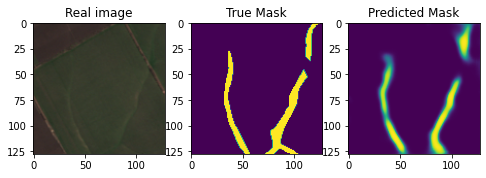

In [31]:
n = 0 # position os image in test set

fig, ax = plt.subplots(1, 3, figsize=(8,8))
ax[0].imshow(test_images[n])
ax[0].set_title('Real image')
ax[2].imshow(y_pred[n])
ax[2].set_title('Predicted Mask')
ax[1].imshow(test_masks[n])
ax[1].set_title('True Mask')


plt.show()